In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import ast
from scipy.stats import weibull_min
from scipy.stats import lognorm, gamma, expon
from statsmodels.tsa.stattools import acf
from dateutil.parser import isoparse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from striprtf.striprtf import rtf_to_text


# Set universal font sizes using rcParams
plt.rcParams['axes.labelsize'] = 15  # For x and y labels
plt.rcParams['xtick.labelsize'] = 14 # For x-ticks
plt.rcParams['ytick.labelsize'] = 14  # For y-ticks
plt.rcParams['legend.fontsize'] = 15  # For legend
plt.rcParams['axes.titlesize'] = 15

In [2]:
def read_rtf_and_convert(input_file):
    try:
        with open(input_file, 'r') as file:
            rtf_content = file.read()
        plain_text = rtf_to_text(rtf_content)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    

    formatted_text_content = plain_text.replace(" ", ", ")
    lifespan = [float(x) for x in ast.literal_eval(formatted_text_content)]
    
    return lifespan

In [3]:
def adjust_before_fit(lifespan):
    # Add a small constant to all values to make them strictly positive
    small_constant = 1e-6
    # time_between_failures_adjusted = [x + small_constant for x in time_between_failres]
    lifespan_adjusted = lifespan
    return lifespan_adjusted

In [4]:
def plot_cdf(data, axs, storage):
    data_sorted = np.sort(data)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    
    if storage == 'alpine':
        axs.plot(data_sorted, cdf, linestyle='solid', linewidth='2', color='blue', label='Data')
    else:
        axs.plot(data_sorted, cdf, linestyle='solid', linewidth='2', color='blue')

In [5]:
# Function to plot Weibull CDF
def plot_weibull_cdf(data, axs, storage):
    # Sort the data
    data_sorted = np.sort(data)
    data_min = data_sorted.min()
    data_max = data_sorted.max()

    # Fit a Weibull distribution to the data
    shape, loc, scale = weibull_min.fit(data_sorted, floc=0)
    log_likelihood = np.sum(weibull_min.logpdf(data_sorted, shape, loc, scale))
    print(f"Weibull parameters: shape={shape}, loc={loc}, scale={scale}, log-likelihood={log_likelihood}")


    # Generate Weibull CDF values
    # First Generate x-axis values
    # Since our plot is in log scale, we want more datapoints to concentrate on the left side
    # We do so by generating x values using log scale as well
    num_points = 10000
    x_min, x_max = 1, 8  # Avoid zero in log scale

    # Generate linearly spaced data
    linear_data = np.linspace(x_min, x_max, num_points)

    # Apply a power transformation
    power = 10  # Adjust this power to control the skewness
    transformed_data = linear_data**power

    # Normalize to maintain the original range
    transformed_data = (transformed_data - transformed_data.min()) / (transformed_data.max() - transformed_data.min())
    x = transformed_data * (data_max - data_min) + data_min
    # x = np.linspace(min(data_sorted), max(data_sorted), 1000000)
    weibull_cdf = weibull_min.cdf(x, shape, loc, scale)

    # Plot the Weibull CDF
    if storage == 'alpine':
        axs.plot(x, weibull_cdf, linestyle='dashed', linewidth='2', color='deeppink', label='Weibull')
    else:
        axs.plot(x, weibull_cdf, linestyle='dashed', linewidth='2', color='deeppink')


In [6]:
# Function to plot Lognormal CDF
def plot_lognormal_cdf(data, axs, storage):
    # Sort the data
    data_sorted = np.sort(data)
    data_min = data_sorted.min()
    data_max = data_sorted.max()

    # Fit a lognormal distribution to the data
    shape, loc, scale = lognorm.fit(data, floc=0)
    log_likelihood = np.sum(lognorm.logpdf(data_sorted, shape, loc, scale))
    print(f"Lognormal parameters: shape={shape}, loc={loc}, scale={scale}, log-likelihood={log_likelihood}")


    # Generate CDF values
    # First Generate x-axis values
    # Since our plot is in log scale, we want more datapoints to concentrate on the left side
    # We do so by generating x values using log scale as well
    num_points = 10000
    x_min, x_max = 1, 8  # Avoid zero in log scale

    # Generate linearly spaced data
    linear_data = np.linspace(x_min, x_max, num_points)

    # Apply a power transformation
    power = 10  # Adjust this power to control the skewness
    transformed_data = linear_data**power

    # Normalize to maintain the original range
    transformed_data = (transformed_data - transformed_data.min()) / (transformed_data.max() - transformed_data.min())
    x = transformed_data * (data_max - data_min) + data_min

    # x = np.linspace(min(data_sorted), max(data_sorted), 1000000)
    lognorm_cdf = lognorm.cdf(x, shape, loc, scale)

    # Plot the Weibull CDF
    if storage == 'alpine':
        axs.plot(x, lognorm_cdf, linestyle='dashdot', linewidth='2', color='forestgreen', label='Lognormal')
    else:
        axs.plot(x, lognorm_cdf, linestyle='dashdot', linewidth='2', color='forestgreen')

In [7]:
# Function to plot Gamma CDF
def plot_gamma_cdf(data, axs, storage):
    # Sort the data
    data_sorted = np.sort(data)
    data_min = data_sorted.min()
    data_max = data_sorted.max()

    # Fit a Gamma distribution to the data
    shape, loc, scale = gamma.fit(data, floc=0)
    log_likelihood = np.sum(gamma.logpdf(data_sorted, shape, loc, scale))
    print(f"Gamma parameters: shape={shape}, loc={loc}, scale={scale}, log-likelihood={log_likelihood}")


    # Generate Gamma CDF values
    num_points = 10000
    x_min, x_max = 1, 8  # Avoid zero in log scale

    # Generate linearly spaced data
    linear_data = np.linspace(x_min, x_max, num_points)

    # Apply a power transformation
    power = 10  # Adjust this power to control the skewness
    transformed_data = linear_data**power

    # Normalize to maintain the original range
    transformed_data = (transformed_data - transformed_data.min()) / (transformed_data.max() - transformed_data.min())
    x = transformed_data * (data_max - data_min) + data_min

    gamma_cdf = gamma.cdf(x, shape, loc, scale)

    # Plot the Gamma CDF
    if storage == 'alpine':
        axs.plot(x, gamma_cdf, linestyle='dotted', linewidth='2', color='orangered', label='Gamma')
    else:
        axs.plot(x, gamma_cdf, linestyle='dotted', linewidth='2', color='orangered')



In [8]:
# Function to plot Exponential CDF
def plot_exponential_cdf(data, axs, storage):
    # Sort the data
    data_sorted = np.sort(data)
    data_min = data_sorted.min()
    data_max = data_sorted.max()

    # Fit an Exponential distribution to the data
    loc, scale = expon.fit(data, floc=0)
    log_likelihood = np.sum(expon.logpdf(data_sorted, loc, scale))
    print(f"Exponential parameters: loc={loc}, scale={scale}, log-likelihood={log_likelihood}")
       # Generate Exponential CDF values
    num_points = 10000
    x_min, x_max = 1, 8  # Avoid zero in log scale

    # Generate linearly spaced data
    linear_data = np.linspace(x_min, x_max, num_points)

    # Apply a power transformation
    power = 10  # Adjust this power to control the skewness
    transformed_data = linear_data**power

    # Normalize to maintain the original range
    transformed_data = (transformed_data - transformed_data.min()) / (transformed_data.max() - transformed_data.min())
    x = transformed_data * (data_max - data_min) + data_min

    exponential_cdf = expon.cdf(x, loc, scale)

    # Plot the Exponential CDF
    if storage == 'alpine':
        axs.plot(x, exponential_cdf, linestyle='dashdot', linewidth='2', color='darkviolet', label='Exponential')
    else:
        axs.plot(x, exponential_cdf, linestyle='dashdot', linewidth='2', color='darkviolet')


In [9]:
def generate_plots(alpine_adjusted, camp_adjusted):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    plot_cdf(alpine_adjusted, axs[0], 'alpine')
    plot_weibull_cdf(alpine_adjusted, axs[0], 'alpine')
    plot_lognormal_cdf(alpine_adjusted, axs[0], 'alpine')
    plot_gamma_cdf(alpine_adjusted, axs[0], 'alpine')
    plot_exponential_cdf(alpine_adjusted, axs[0], 'alpine')
    
    
    axs[0].set_xlabel('Lifespan (hours)')
    axs[0].set_ylabel('CDF')
    axs[0].set_title('(a) Alpine', pad=34)
    axs[0].set_xscale('log')
    axs[0].set_xlim(10, 100000)
    axs[0].grid(True, linestyle=':', alpha=0.8)
    
    
    
    plot_cdf(camp_adjusted, axs[1], 'campaign')
    plot_weibull_cdf(camp_adjusted, axs[1], 'campaign')
    plot_lognormal_cdf(camp_adjusted, axs[1], 'campaign')
    plot_gamma_cdf(camp_adjusted, axs[1], 'campaign')
    plot_exponential_cdf(camp_adjusted, axs[1], 'campaign')
    
    
    axs[1].set_xlabel('Lifespan (hours)')
    axs[1].set_title('(a) Campaign', pad=34)
    axs[1].set_xscale('log')
    axs[1].set_xlim(10, 100000)
    axs[1].grid(True, linestyle=':', alpha=0.8)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=5)


    plt.savefig('lifespan_fit.pdf', bbox_inches='tight')

    plt.show()

In [10]:
def main():
    alpine_lifespan = read_rtf_and_convert('poh-lifespan-alpine.rtf')
    camp_lifespan = read_rtf_and_convert('poh-lifespan-campaign.rtf')
    
    alpine_adjusted = adjust_before_fit(alpine_lifespan)
    camp_adjusted = adjust_before_fit(camp_lifespan)
    
    generate_plots(alpine_adjusted, camp_adjusted)

Weibull parameters: shape=0.4470012628333564, loc=0, scale=1520.6116631915772, log-likelihood=-4136.455827367245
Lognormal parameters: shape=2.2171012648939095, loc=0.0, scale=479.42761936579996, log-likelihood=-4084.8255190832183
Gamma parameters: shape=0.31398355204040757, loc=0, scale=13506.404052090655, log-likelihood=-4179.794556802308
Exponential parameters: loc=0.0, scale=4240.788719568378, log-likelihood=-4554.669715700386
Weibull parameters: shape=0.5058264204106293, loc=0, scale=2044.4804885516587, log-likelihood=-2411.9630829201355
Lognormal parameters: shape=2.6840596733219284, loc=0.0, scale=610.8159310594829, log-likelihood=-2443.434905373439
Gamma parameters: shape=0.37758591631786614, loc=0, scale=9393.924462978019, log-likelihood=-2404.4464314406096
Exponential parameters: loc=0.0, scale=3547.013576174374, log-likelihood=-2541.1595751902532


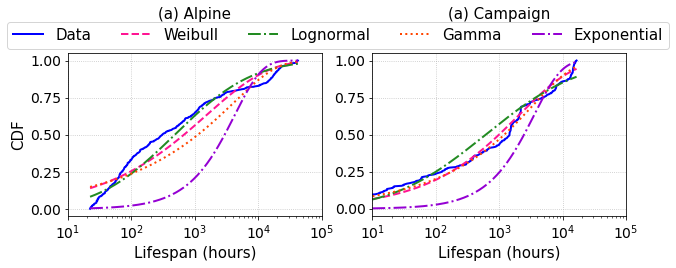

In [11]:
if __name__ == "__main__":
    main()